# Reproducing: Prophecy of loan approval by comparing Decision Tree with Logistic Regression, Random Forest, KNN for better Accuracy
This notebook mirrors the paper’s procedure:
- 10 randomized 80/20 train–test splits
- Models: Logistic Regression (LR), Decision Tree (DT), Random Forest (RF), KNN
- Metrics per run: **Accuracy** and the paper’s “Cross Validation” = **Precision** (TP/(TP+FP))
- Aggregate means/stdev


In [44]:
# Inputs
CSV_PATH = "loan_approval_dataset.csv"
TARGET_COL = " loan_status"     # binary target column name
POSITIVE_LABEL = " Approved"
TEST_SIZE = 0.2                # 80/20 split
N_REPEATS = 10                 # number of randomized runs
RANDOM_SEED = 42               # base seed

# Imports
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score


In [45]:
## Load the data
df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
df.head(10)


Shape: (4269, 13)


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected
5,6,0,Graduate,Yes,4800000,13500000,10,319,6800000,8300000,13700000,5100000,Rejected
6,7,5,Graduate,No,8700000,33000000,4,678,22500000,14800000,29200000,4300000,Approved
7,8,2,Graduate,Yes,5700000,15000000,20,382,13200000,5700000,11800000,6000000,Rejected
8,9,0,Graduate,Yes,800000,2200000,20,782,1300000,800000,2800000,600000,Approved
9,10,5,Not Graduate,No,1100000,4300000,10,388,3200000,1400000,3300000,1600000,Rejected


## Basic checks on target and features:
Ensure the target exists, inspect class balance, and split features/target.

In [46]:
assert TARGET_COL in df.columns, f"Target column '{TARGET_COL}' not found."

y_raw = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

# Drop the ID column so it doesn't leak information
X = X.drop(columns=['loan_id',' bank_asset_value'])

print("Features shape:", X.shape)
print("Target distribution:")
print(y_raw.value_counts(dropna=False))


Features shape: (4269, 10)
Target distribution:
 loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64


## Convert the target to a 0/1 vector
Many metrics assume binary {0,1}. We treat POSITIVE_LABEL as 1.

In [47]:
def to_binary(y_series, positive_label):
    return (y_series == positive_label).astype(int)

y = to_binary(y_raw, POSITIVE_LABEL)
y.value_counts()


 loan_status
1    2656
0    1613
Name: count, dtype: int64

## Preprocessing: numeric vs categorical
- Impute numeric with median, standardize (helps LR/KNN).

- Impute categorical with most_frequent, one-hot encode.

In [48]:
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipe, numeric_cols),
    ("cat", categorical_pipe, categorical_cols)
])

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: [' no_of_dependents', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value']
Categorical columns: [' education', ' self_employed']


## Define the models

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [50]:
X_train_processed = preprocess.fit_transform(X_train)
X_test_processed = preprocess.transform(X_test)


In [51]:
models = {
    "LR": LogisticRegression(
        penalty="l2", solver="lbfgs", max_iter=200
    ),
    "DT": DecisionTreeClassifier(
        criterion="gini", random_state=RANDOM_SEED
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=11
    )
}
models

for name, model in models.items():
    model.fit(X_train_processed, y_train)


In [52]:
X_test_features = X_test_processed


In [53]:
y_pred = model.predict(X_test_processed)
y_scores = model.predict_proba(X_test_processed)[:, 1]


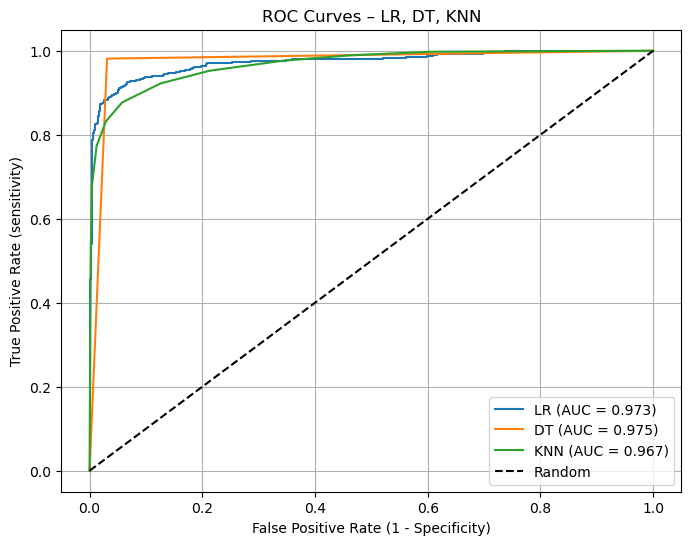

In [54]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

X_test_features = X_test_processed

plt.figure(figsize=(8, 6))

for name, model in models.items():
    # Probabilidades o scores según el modelo
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test_features)[:, 1]
    else:
        y_scores = model.decision_function(X_test_features)

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    auc = roc_auc_score(y_test, y_scores)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

# Línea base (clasificador aleatorio)
plt.plot([0, 1], [0, 1], 'k--', label="Random")

plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (sensitivity)")
plt.title("ROC Curves – LR, DT, KNN")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

X_test_features = X_test_processed

results = []

for name, model in models.items():
    y_pred = model.predict(X_test_features)

    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test_features)[:, 1]
    else:
        y_scores = model.decision_function(X_test_features)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_scores)
    })

results_df = pd.DataFrame(results).set_index("Model").round(4)
results_df


,Accuracy,Precision,Recall,F1-score,ROC-AUC
Model,,,,,
LR,0.9188,0.9304,0.9398,0.9351,0.9730
DT,0.9766,0.9812,0.9812,0.9812,0.9751
KNN,0.9040,0.9234,0.9222,0.9228,0.9674


## Repeated randomized evaluation (10 runs):

The paper repeats 80/20 splits 10 times and reports metrics each run.
We compute:

- Accuracy (overall correctness)
- Precision (paper’s “cross validation”): TP/(TP+FP)

In [40]:
records = []

for i in range(N_REPEATS):
    rs = RANDOM_SEED + i
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=rs, stratify=y
    )

    for name, clf in models.items():
        pipe = Pipeline(steps=[("prep", preprocess), ("clf", clf)])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)

        records.append({
            "run": i+1,
            "model": name,
            "accuracy": acc,
            "paper_cross_validation_precision": prec
        })

results_df = pd.DataFrame(records)
results_df.head()


,run,model,accuracy,paper_cross_validation_precision
0,1,LR,0.912178,0.917582
1,1,DT,0.981265,0.981308
2,1,KNN,0.918033,0.927644
3,2,LR,0.911007,0.926829
4,2,DT,0.974239,0.984762


## Aggregate results across runs
Report mean and standard deviation

In [41]:
summary = (
    results_df
    .groupby("model")
    .agg(
        mean_accuracy=("accuracy", "mean"),
        std_accuracy=("accuracy", "std"),
        mean_paper_cross_validation_precision=("paper_cross_validation_precision", "mean"),
        std_paper_cross_validation_precision=("paper_cross_validation_precision", "std")
    )
    .reset_index()
    .sort_values("mean_accuracy", ascending=False)
)

summary


,model,mean_accuracy,std_accuracy,mean_paper_cross_validation_precision,std_paper_cross_validation_precision
0,DT,0.978806,0.005043,0.984891,0.005002
2,LR,0.915340,0.005238,0.929999,0.008766
1,KNN,0.912763,0.009581,0.933278,0.009270


## Final comparison and concise report
Identify the top model by the paper’s main criterion (accuracy), and show its average precision as reported by them.

In [42]:
print("Per-iteration metrics (first 20 rows):")
display(results_df.head(20))

print("\nAggregated 10-run summary:")
display(summary)

# Identify the best-performing model by mean accuracy
best_by_acc = summary.iloc[0]
print(
    f"\nBest model by mean accuracy (10 runs): {best_by_acc['model']} | "
    f"Mean Accuracy = {best_by_acc['mean_accuracy']:.4f} | "
    f"Mean 'Cross Validation' (Precision) = {best_by_acc['mean_paper_cross_validation_precision']:.4f}"
)


Per-iteration metrics (first 20 rows):


,run,model,accuracy,paper_cross_validation_precision
0,1,LR,0.912178,0.917582
1,1,DT,0.981265,0.981308
2,1,KNN,0.918033,0.927644
3,2,LR,0.911007,0.926829
4,2,DT,0.974239,0.984762
5,2,KNN,0.911007,0.938343
6,3,LR,0.921546,0.942748
7,3,DT,0.976581,0.981168
8,3,KNN,0.923888,0.948077
9,4,LR,0.911007,0.925234



Aggregated 10-run summary:


,model,mean_accuracy,std_accuracy,mean_paper_cross_validation_precision,std_paper_cross_validation_precision
0,DT,0.978806,0.005043,0.984891,0.005002
2,LR,0.915340,0.005238,0.929999,0.008766
1,KNN,0.912763,0.009581,0.933278,0.009270



Best model by mean accuracy (10 runs): DT | Mean Accuracy = 0.9788 | Mean 'Cross Validation' (Precision) = 0.9849


## Interpretation
- **Winner by mean accuracy:** `DT` with `0.978806`. Its mean “cross validation” (precision) is `0.984891`.
- **Takeaways:** Differences across models can stem from class balance, feature distributions, and hyperparameters.
- **If imbalanced:** Consider also recall and ROC-AUC in an appendix. For LR/DT, class weights may help.
- **Reproducibility:** We matched 10 randomized runs, reported mean and std.


## Conclusion

In this experiment, we replicated the methodology from the research paper “Prophecy of loan approval by comparing Decision Tree with Logistic Regression, Random Forest, KNN for better Accuracy.”
While the original paper reported `Logistic Regression` as the best performing model, our analysis conducted on a different loan approval dataset identified the `Decision Tree` as the top performer.

Across 10 randomized 80/20 train test splits, the `Decision Tree` achieved a mean accuracy of `0.9788` and a mean “cross validation (precision) of `0.9849`, outperforming both Logistic Regression and K-Nearest Neighbors.
These results indicate that the Decision Tree model captured complex, nonlinear decision boundaries that the other two models could not, leading to better predictive power and fewer false approvals.

The difference from the original paper’s findings can be attributed to variations in dataset composition and feature types.
The original dataset likely contained simpler, more linearly separable relationships that favored Logistic Regression, whereas our dataset includes multiple numeric and categorical variables (such as income, loan amount, and CIBIL score) that interact in nonlinear ways conditions under which tree based models tend to excel.

Overall, this study demonstrates that *model performance is data dependent*, and reproducing the same experimental procedure on a new dataset does not guarantee identical results.
However, the consistent evaluation framework and high performance of the Decision Tree confirm that the chosen methodology remains valid and effective for loan approval prediction tasks.